# Gamma Ray Bursts

In [18]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [19]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_15568\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [20]:
T90  = data[6]
T100 = data[12]
F    = data[9]
R    = data[11] 

In [21]:
# Assume T90, T100, F, R are arrays of strings
X = np.vstack([T90, T100, F, R]).T  # Shape: (n_samples, 4)

# Mask rows that do NOT contain the string '-999'
mask = ~np.any(X == '-999', axis=1)

# Keep only clean rows
Y = X[mask]

Y = Y.astype(float)

In [34]:
Y_train, Y_test = train_test_split(Y, test_size=0.3)

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(Y_train)
Y_train_transformed = scaler.transform(Y_train)
Y_test_transformed = scaler.transform(Y_test)

In [38]:
def plot_scatter_matrix(data, title_prefix=""):
    dim = data.shape[0]
    fig, axes = plt.subplots(dim, dim, figsize=(4 * dim, 4 * dim))

    for i in range(dim):
        for j in range(dim):
            ax = axes[i, j] if dim > 1 else axes
            ax.scatter(data[j], data[i], marker='.', alpha=0.5)
            if i == dim - 1:
                ax.set_xlabel(f'{title_prefix}[{j}]')
            if j == 0:
                ax.set_ylabel(f'{title_prefix}[{i}]')
            ax.set_title(f'{title_prefix}[{i}] vs {title_prefix}[{j}]')
            ax.grid(True)

    plt.tight_layout()
    plt.show()

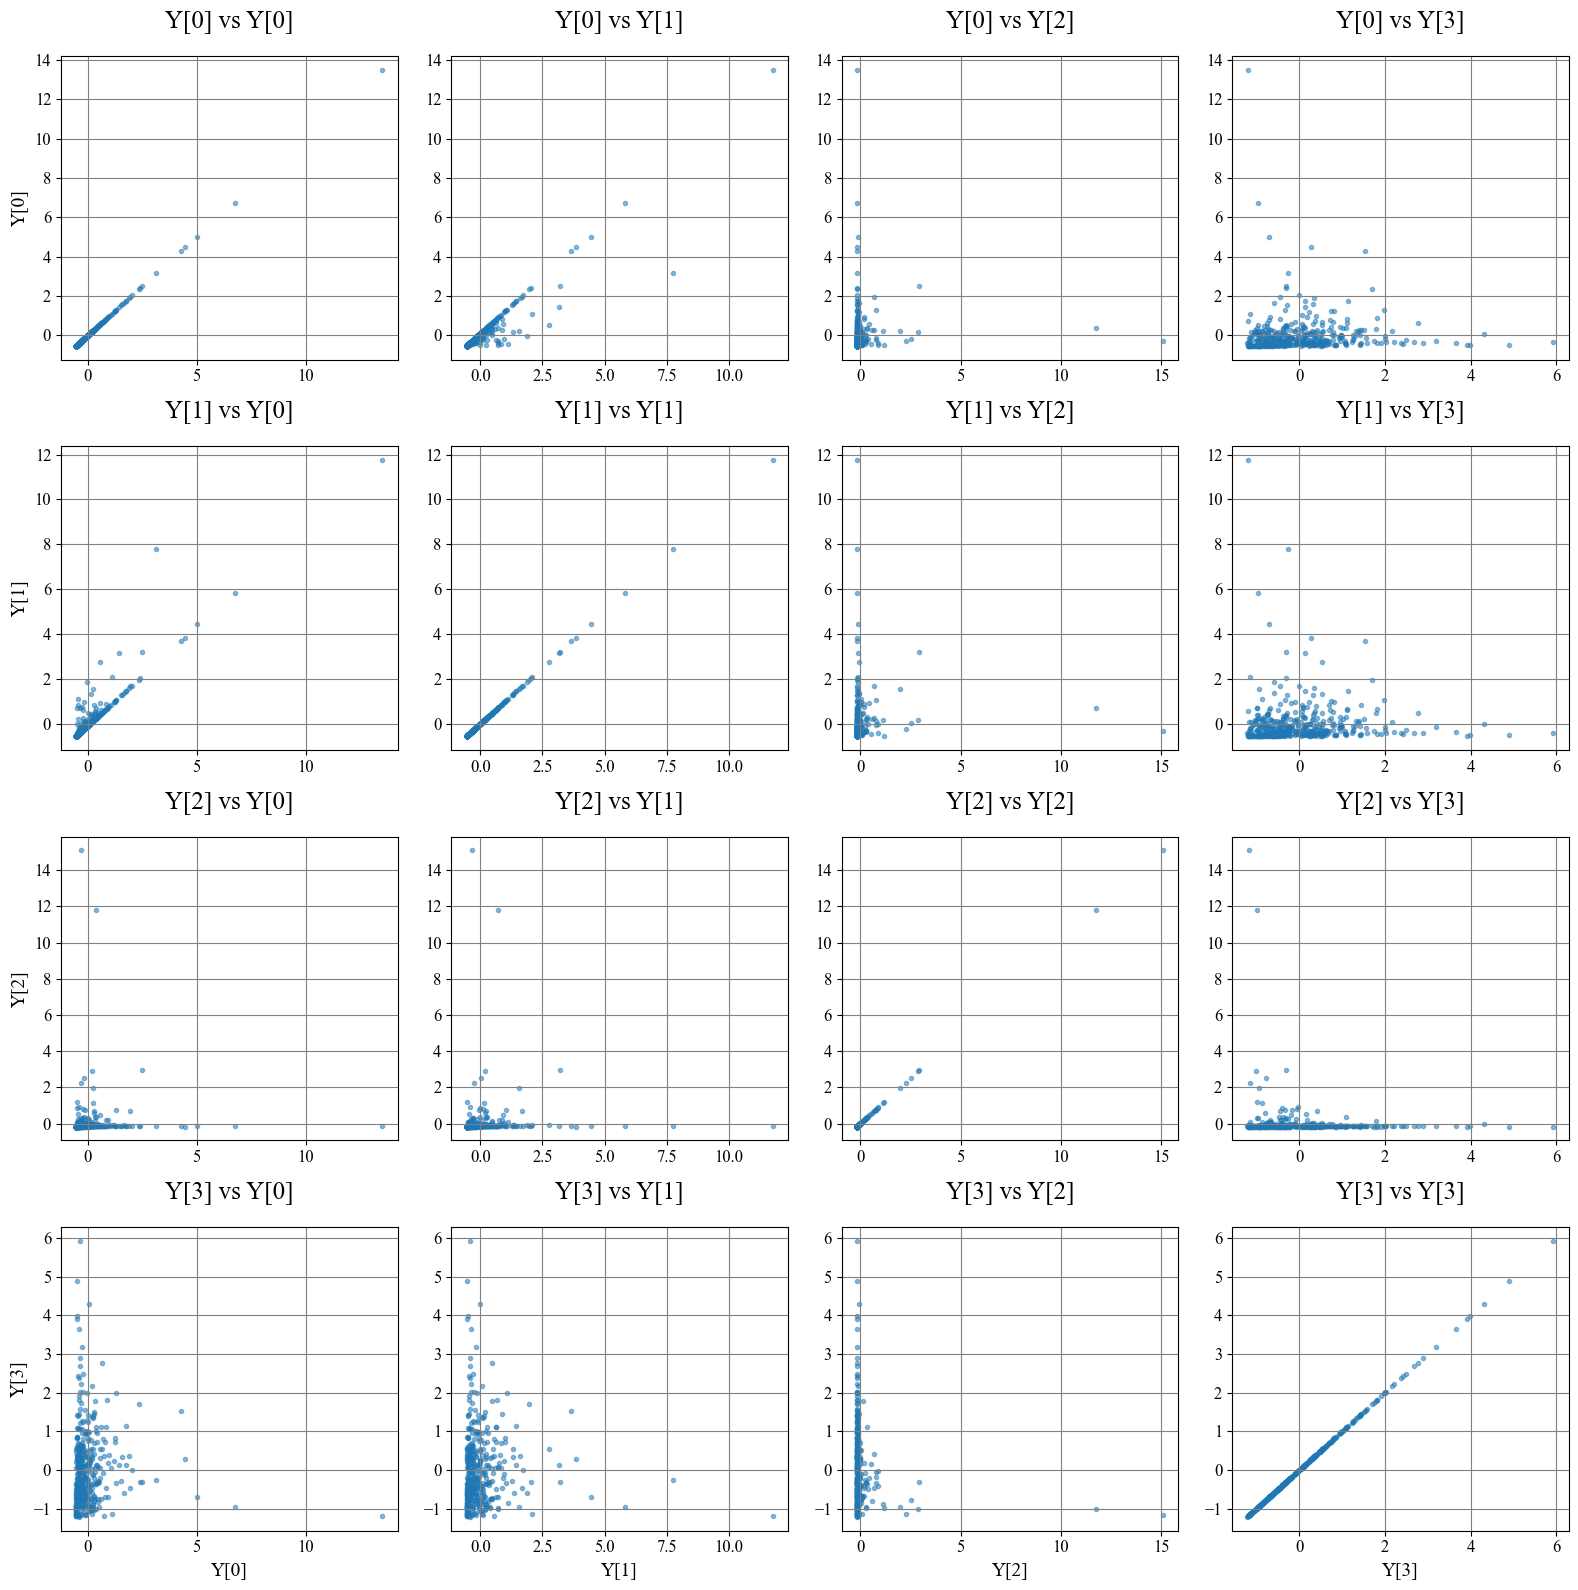

In [39]:
plot_scatter_matrix(Y_train_transformed.T, "Y")

In [40]:
from sklearn.decomposition import PCA

In [41]:
pca = PCA(n_components=4)

In [42]:
pca.fit(Y_train_transformed)

PCA(n_components=4)

In [43]:
pca.explained_variance_ratio_

array([0.48341728, 0.2782316 , 0.22109528, 0.01725584])

Thus major part of the variance is contained into the first three dimensions $\to$ T90, T100, fluence. I'll use just these to cluster my data

In [50]:
A_train = pca.transform(Y_train_transformed)  # oppure [:2] per visualizzazione
A_test  = pca.transform(Y_test_transformed)

In [64]:
A = np.vstack([A_train, A_test])


In [66]:
scores = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(A_train)
    labels = kmeans.predict(A)
    score = silhouette_score(A, labels)
    scores.append(score)

best_k = k_range[np.argmax(scores)]
print("Best k by silhouette score:", best_k)

Best k by silhouette score: 3


Text(0.5, 1.0, 'Hyperparameter tuning')

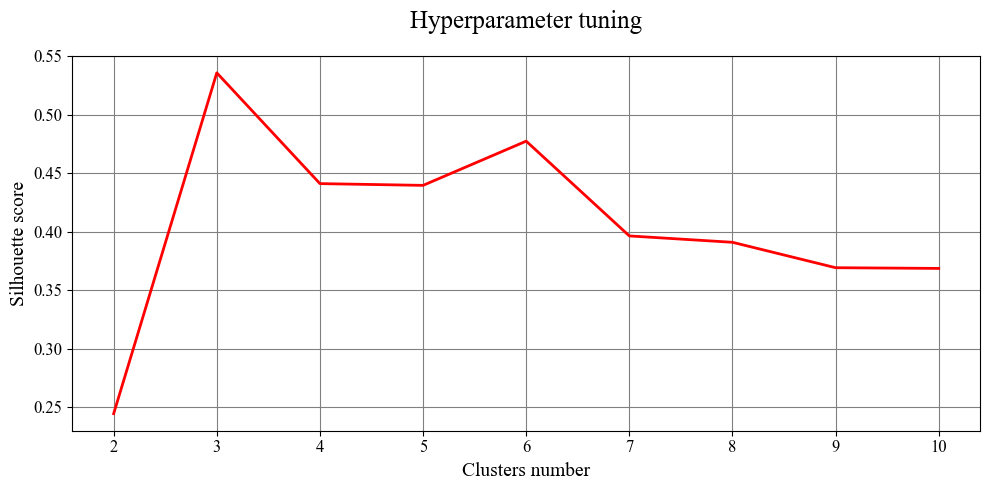

In [67]:
plt.plot(k_range, scores, lw=2, color='red')
plt.xlabel('Clusters number')
plt.ylabel('Silhouette score')
plt.title('Hyperparameter tuning')

In [68]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(A_train)
labels = kmeans.predict(A)

In [69]:
# Inverti PCA + StandardScaler
Y_reconstructed = pca.inverse_transform(A)
Y_original_space = scaler.inverse_transform(Y_reconstructed)

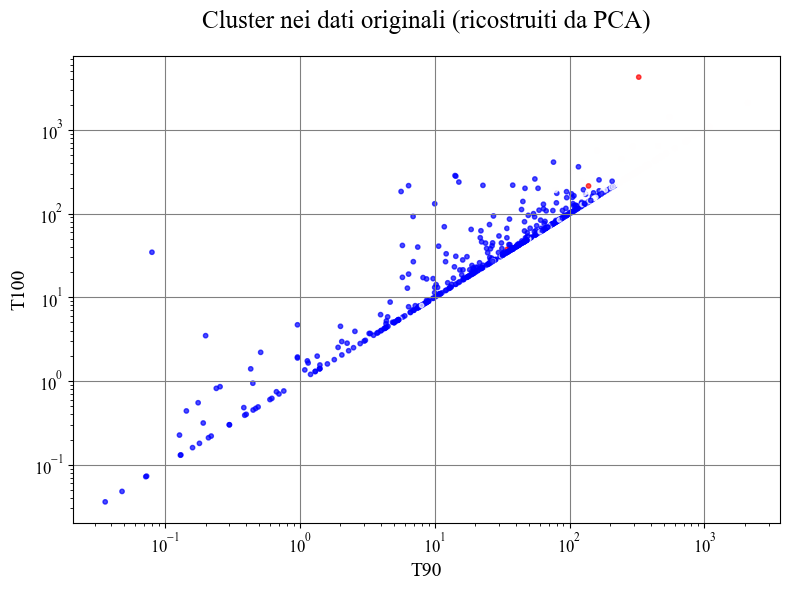

In [70]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 0],  # ad esempio T90
    Y_original_space[:, 1],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("T90")
plt.ylabel("T100")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()

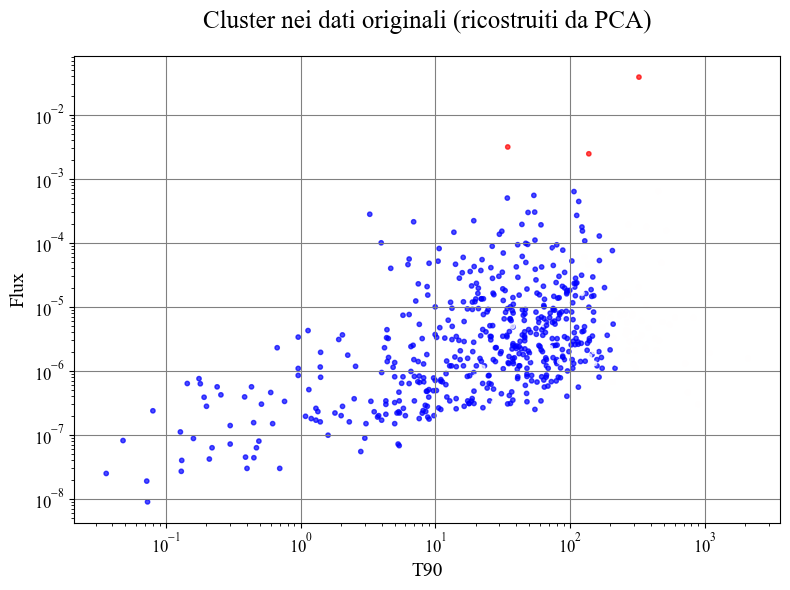

In [71]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 0],  # ad esempio T90
    Y_original_space[:, 2],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("T90")
plt.ylabel("Flux")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()

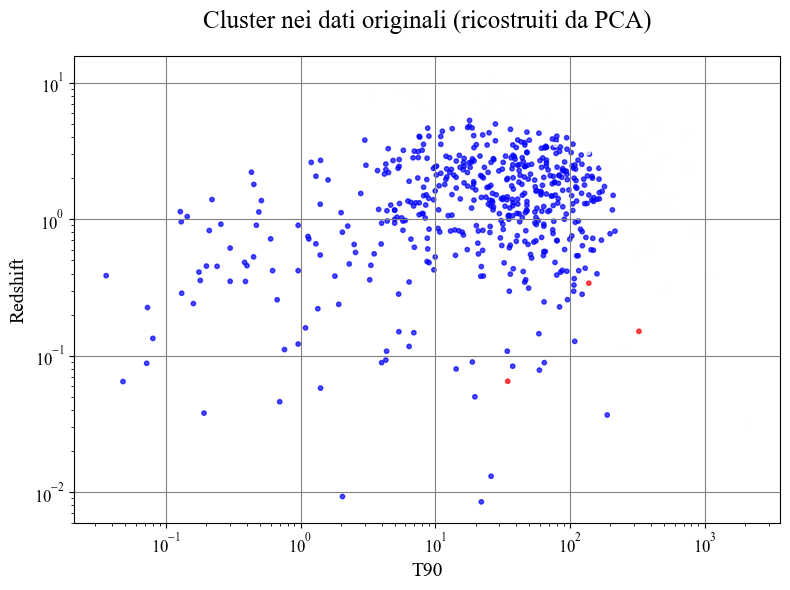

In [72]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 0],  # ad esempio T90
    Y_original_space[:, 3],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("T90")
plt.ylabel("Redshift")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()

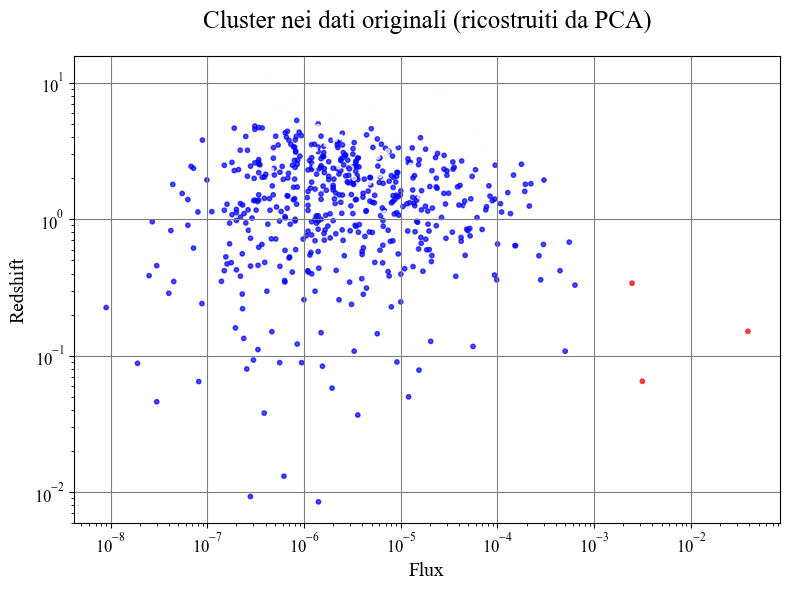

In [73]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    Y_original_space[:, 2],  # ad esempio T90
    Y_original_space[:, 3],  # ad esempio T100
    c=labels,                # color coding basato sui cluster
    cmap='bwr',              # blu e rosso (puoi usare anche 'viridis', 'Set1' etc.)
    s=10,
    alpha=0.7,
    label='Dati ricostruiti'
)
plt.xlabel("Flux")
plt.ylabel("Redshift")
plt.title("Cluster nei dati originali (ricostruiti da PCA)")
plt.loglog()
plt.tight_layout()